In [6]:
import os
import tensorflow as tf
import numpy as np
from numpy import load

from matplotlib import pyplot
from matplotlib.image import imread

from keras.models import Sequential
from keras.layers import Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import SGD, Adadelta, Adam, Adagrad
from keras.initializers import RandomNormal
from keras.initializers import HeNormal, GlorotUniform
import tensorflow as tf
import datetime
from tensorboard import notebook
import tensorflow_addons as tfa
from keras import backend as K
from sklearn.model_selection import train_test_split

In [3]:
#pip install keras
#!pip install tensorflow-addons
#!pip install -q pyyaml h5py 
%load_ext tensorboard

notebook.list()

### Loading dataset, reshaping and saving to .npy
#### Using kaggle.com cats_vs_dogs dataset, only "train" folder is used

In [ ]:
# # loading dataset, reshaping and saving to 
# from os import listdir
# from numpy import asarray
# from numpy import save
# from keras.preprocessing.image import load_img
# from keras.preprocessing.image import img_to_array
# # define location of dataset
# folder = 'train/'
# photos, labels = list(), list()
# # enumerate files in the directory
# for file in listdir(folder):
#   # determine class
#     output = 0.0
#     if file.startswith('cat'):
#         output = 1.0
#   # load image
#     photo = load_img(folder + file, target_size=(200, 200))
#   # convert to numpy array
#     photo = img_to_array(photo)
#   # store
#     photos.append(photo)
#     labels.append(output)
# # convert to a numpy arrays
# photos = asarray(photos)
# labels = asarray(labels)
# print(photos.shape, labels.shape)
# # save the reshaped photos
# save('dogs_vs_cats_photos.npy', photos)
# save('dogs_vs_cats_labels.npy', labels)

### Loading .npy in variables (12 GB RAM required)

In [2]:
### loading dataset into variables in one run + normalization
train_set, valid_set, train_labels, valid_labels = train_test_split(load('dogs_vs_cats_photos.npy').reshape(25000, 120000) / 255.0, load('dogs_vs_cats_labels.npy'), train_size=0.8, test_size=0.2)

### Tensorboard init + short info about the structure of all available models

In [5]:
### MODEL INFO
# model1 - 1 sigmoid norm init + SGD
# model2 - 1 relu He init + 1 sigmoid norm init + SGD
# model3 - 3 relu He init + sigmoid He + SGD
# model4 - 4 tanh GlorotUniform init + sigmoid GlorotUniform init + SGD
# model5 - 4 elu He init + sigmoid He init + SGD
# model6 - 4 elu He init + sigmoid He init + Adadelta
# model7 - 4 elu He init + sigmoid He init + Adam
# model8 - 4 elu He init + sigmoid He init + Adagrad
# model11 - 5 elu He init + sigmoid He init + Adadelta
# model12 - 4 elu He init + sigmoid He init + Adadelta + Batch norm
# model13 - 4 elu He init + sigmoid He init + Adadelta + Dropout + Batch norm
# model14 - 4 leaky relu He init + sigmoid He init + Adadelta
# model15 - 4 param relu He init + sigmoid He init + Adadelta
# model16 - 4 elu He init + sigmoid He init + Adadelta + Dropout + Batch norm + l1 l2 + max norm + Early Stop
# model17 - 4 leaky relu He init + sigmoid He init + Adadelta + Batch norm + Dropout + Early Stop
# model18 - 4 leaky relu He init + sigmoid He init + Adadelta + Batch norm + Dropout + l1 l2 + Early Stop

%tensorboard --logdir logs --host localhost

Reusing TensorBoard on port 6006 (pid 8112), started 0:04:35 ago. (Use '!kill 8112' to kill it.)

### Custom metric F1

In [3]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Model 1 - sigmoid norm init + SGD

In [6]:
def define_model():     ### sigmoid only
    model = Sequential()
    model.add(Dense(1, activation='sigmoid', kernel_initializer=RandomNormal(mean=0., stddev=1.)))
    # compile model
    opt = SGD()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])
    return model

In [7]:
### model 1, simplest 1 sigmoid, normal init
model = define_model()
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

log_dir = "logs/model1/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [8]:
model.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=20, callbacks=[cp_callback, tensorboard_callback])

Epoch 1/20
625/625 [==============================] - 5s 7ms/step - loss: 26.8996 - accuracy: 0.5143 - auc: 0.5157 - f1: 0.4641 - val_loss: 28.0675 - val_accuracy: 0.5152 - val_auc: 0.5149 - val_f1: 0.2122

Epoch 00001: saving model to training_1\cp.ckpt
Epoch 2/20
625/625 [==============================] - 3s 5ms/step - loss: 22.0648 - accuracy: 0.5292 - auc: 0.5315 - f1: 0.4741 - val_loss: 22.7616 - val_accuracy: 0.5174 - val_auc: 0.5243 - val_f1: 0.2606

Epoch 00002: saving model to training_1\cp.ckpt
Epoch 3/20
625/625 [==============================] - 3s 5ms/step - loss: 22.4803 - accuracy: 0.5365 - auc: 0.5361 - f1: 0.4719 - val_loss: 20.1299 - val_accuracy: 0.5468 - val_auc: 0.5530 - val_f1: 0.6490

Epoch 00003: saving model to training_1\cp.ckpt
Epoch 4/20
625/625 [==============================] - 3s 5ms/step - loss: 21.3837 - accuracy: 0.5477 - auc: 0.5496 - f1: 0.4876 - val_loss: 13.2990 - val_accuracy: 0.5436 - val_auc: 0.5477 - val_f1: 0.4933

Epoch 00004: saving model to

In [9]:
### model 1
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 120001    
Total params: 120,001
Trainable params: 120,001
Non-trainable params: 0
_________________________________________________________________


In [10]:
### saving final model 1 
#!mkdir -p saved_model
model.save('saved_model/model1')

INFO:tensorflow:Assets written to: saved_model/model1\assets


### Model 2 - 1 relu He init + 1 sigmoid norm init + SGD

In [11]:
def define_model2():     ### one relu 
    model = Sequential()
    model.add(Dense(100, activation='relu', kernel_initializer=HeNormal()))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=RandomNormal(mean=0., stddev=1.)))
    # compile model
    opt = SGD()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])
    return model

In [12]:
### model 2, 1 relu + sigmoid, He + normal initializer
model2 = define_model2()
checkpoint_path2 = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path2)
cp_callback2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path2,
                                                 save_weights_only=True,
                                                 verbose=1)

log_dir2 = "logs/model2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback2 = tf.keras.callbacks.TensorBoard(log_dir=log_dir2, histogram_freq=1)

In [13]:
model2.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=20, callbacks=[cp_callback2, tensorboard_callback2])

Epoch 1/20
625/625 [==============================] - 17s 26ms/step - loss: 5.6532 - accuracy: 0.4956 - auc: 0.4984 - f1: 0.3624 - val_loss: 0.6851 - val_accuracy: 0.5556 - val_auc: 0.5623 - val_f1: 0.4131

Epoch 00001: saving model to training_2\cp.ckpt
Epoch 2/20
625/625 [==============================] - 15s 24ms/step - loss: 0.6806 - accuracy: 0.5591 - auc: 0.5694 - f1: 0.4147 - val_loss: 0.6835 - val_accuracy: 0.5624 - val_auc: 0.5745 - val_f1: 0.4815

Epoch 00002: saving model to training_2\cp.ckpt
Epoch 3/20
625/625 [==============================] - 15s 25ms/step - loss: 0.6762 - accuracy: 0.5675 - auc: 0.5797 - f1: 0.4313 - val_loss: 0.6792 - val_accuracy: 0.5598 - val_auc: 0.5758 - val_f1: 0.4430

Epoch 00003: saving model to training_2\cp.ckpt
Epoch 4/20
625/625 [==============================] - 15s 24ms/step - loss: 0.6712 - accuracy: 0.5827 - auc: 0.6100 - f1: 0.5011 - val_loss: 0.6698 - val_accuracy: 0.5916 - val_auc: 0.6161 - val_f1: 0.5172

Epoch 00004: saving model to

In [14]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12000100  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 12,000,201
Trainable params: 12,000,201
Non-trainable params: 0
_________________________________________________________________


In [15]:
model2.save('saved_model/model2')

INFO:tensorflow:Assets written to: saved_model/model2\assets


### Model 3 - 3 relu He init + sigmoid He + SGD

In [16]:
def define_model3():     ### 3 relu
    model = Sequential()
    model.add(Dense(256, activation='relu', kernel_initializer=HeNormal()))
    model.add(Dense(128, activation='relu', kernel_initializer=HeNormal()))
    model.add(Dense(64, activation='relu', kernel_initializer=HeNormal()))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=HeNormal()))
    # compile model
    opt = SGD()
    model.compile(optimizer=opt, loss='y_p ', metrics=['accuracy', 'AUC', f1])
    return model

In [17]:
### 3 relu + sigmoid, He init everywhere
model3 = define_model3()
checkpoint_path3 = "training_3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path3)
cp_callback3 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path3,
                                                 save_weights_only=True,
                                                 verbose=1)

log_dir3 = "logs/model3/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback3 = tf.keras.callbacks.TensorBoard(log_dir=log_dir3, histogram_freq=1)

In [18]:
model3.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=20, callbacks=[cp_callback3, tensorboard_callback3])

Epoch 1/20
625/625 [==============================] - 31s 48ms/step - loss: 0.9746 - accuracy: 0.5355 - auc: 0.5436 - f1: 0.4302 - val_loss: 0.6663 - val_accuracy: 0.5960 - val_auc: 0.6300 - val_f1: 0.5587

Epoch 00001: saving model to training_3\cp.ckpt
Epoch 2/20
625/625 [==============================] - 29s 46ms/step - loss: 0.6612 - accuracy: 0.6020 - auc: 0.6405 - f1: 0.5814 - val_loss: 0.6601 - val_accuracy: 0.5948 - val_auc: 0.6491 - val_f1: 0.5611

Epoch 00002: saving model to training_3\cp.ckpt
Epoch 3/20
625/625 [==============================] - 29s 46ms/step - loss: 0.6527 - accuracy: 0.6145 - auc: 0.6570 - f1: 0.5892 - val_loss: 0.6636 - val_accuracy: 0.6020 - val_auc: 0.6567 - val_f1: 0.5099

Epoch 00003: saving model to training_3\cp.ckpt
Epoch 4/20
625/625 [==============================] - 29s 46ms/step - loss: 0.6422 - accuracy: 0.6231 - auc: 0.6752 - f1: 0.6045 - val_loss: 0.6529 - val_accuracy: 0.6146 - val_auc: 0.6649 - val_f1: 0.5435

Epoch 00004: saving model to

In [19]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               30720256  
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 30,761,473
Trainable params: 30,761,473
Non-trainable params: 0
_________________________________________________________________


In [20]:
model3.save('saved_model/model3')

INFO:tensorflow:Assets written to: saved_model/model3\assets


### Model 4 - 4 tanh GlorotUniform init + sigmoid GlorotUniform init + SGD

In [21]:
def define_model4():     ### 4 tanh
    model = Sequential()
    #model.add(Dense(1084, kernel_initializer=GlorotUniform(), activation='tanh'))
    #model.add(Dense(408, kernel_initializer=GlorotUniform(), activation='tanh'))
    model.add(Dense(512, kernel_initializer=GlorotUniform(), activation='tanh'))
    model.add(Dense(256, kernel_initializer=GlorotUniform(), activation='tanh'))
    model.add(Dense(128, kernel_initializer=GlorotUniform(), activation='tanh'))
    model.add(Dense(64, kernel_initializer=GlorotUniform(), activation='tanh'))
    model.add(Dense(1, kernel_initializer=GlorotUniform(), activation='sigmoid'))
    opt = SGD()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])
    return model

In [22]:
### 4 tanh + sigmoid, Glorot init
model4 = define_model4()
checkpoint_path4 = "training_4/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path4)
cp_callback4 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path4,
                                                 save_weights_only=True,
                                                 verbose=1)

log_dir4 = "logs/model4/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback4 = tf.keras.callbacks.TensorBoard(log_dir=log_dir4, histogram_freq=1)

In [23]:
model4.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=20, callbacks=[cp_callback4, tensorboard_callback4])

Epoch 1/20
625/625 [==============================] - 57s 90ms/step - loss: 0.7019 - accuracy: 0.5515 - auc: 0.5691 - f1: 0.4787 - val_loss: 0.6635 - val_accuracy: 0.5942 - val_auc: 0.6377 - val_f1: 0.5611

Epoch 00001: saving model to training_4\cp.ckpt
Epoch 2/20
625/625 [==============================] - 55s 88ms/step - loss: 0.6574 - accuracy: 0.6041 - auc: 0.6458 - f1: 0.5529 - val_loss: 0.6542 - val_accuracy: 0.6110 - val_auc: 0.6560 - val_f1: 0.5573

Epoch 00002: saving model to training_4\cp.ckpt
Epoch 3/20
625/625 [==============================] - 55s 88ms/step - loss: 0.6449 - accuracy: 0.6212 - auc: 0.6692 - f1: 0.5871 - val_loss: 0.6467 - val_accuracy: 0.6226 - val_auc: 0.6693 - val_f1: 0.5966

Epoch 00003: saving model to training_4\cp.ckpt
Epoch 4/20
625/625 [==============================] - 55s 88ms/step - loss: 0.6382 - accuracy: 0.6311 - auc: 0.6831 - f1: 0.6024 - val_loss: 0.6430 - val_accuracy: 0.6280 - val_auc: 0.6797 - val_f1: 0.6264

Epoch 00004: saving model to

In [24]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               61440512  
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 61,613,057
Trainable params: 61,613,057
Non-trainable params: 0
_________________________________________________________________


In [25]:
model4.save('saved_model/model4')

INFO:tensorflow:Assets written to: saved_model/model4\assets


### Model 5 - 4 elu He init + sigmoid He init + SGD

In [28]:
def define_model5():     ### 4 elu
    model = Sequential()
    model.add(Dense(512, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dense(256, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dense(128, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dense(64, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dense(1, kernel_initializer=HeNormal(), activation='sigmoid'))
    opt = SGD()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])
    return model

In [29]:
### 4 elu + sigmoid, He init, SGD opt
model5 = define_model5()
checkpoint_path5 = "training_5/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path5)
cp_callback5 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path5,
                                                 save_weights_only=True,
                                                 verbose=1)

log_dir5 = "logs/model5/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback5 = tf.keras.callbacks.TensorBoard(log_dir=log_dir5, histogram_freq=1)

In [30]:
model5.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=20, callbacks=[cp_callback5, tensorboard_callback5])

Epoch 1/20
625/625 [==============================] - 56s 88ms/step - loss: 1.0952 - accuracy: 0.5244 - auc: 0.5269 - f1: 0.4061 - val_loss: 0.6676 - val_accuracy: 0.5940 - val_auc: 0.6324 - val_f1: 0.5720

Epoch 00001: saving model to training_5\cp.ckpt
Epoch 2/20
625/625 [==============================] - 54s 86ms/step - loss: 0.6657 - accuracy: 0.5983 - auc: 0.6303 - f1: 0.5633 - val_loss: 0.6737 - val_accuracy: 0.5876 - val_auc: 0.6566 - val_f1: 0.4175

Epoch 00002: saving model to training_5\cp.ckpt
Epoch 3/20
625/625 [==============================] - 54s 86ms/step - loss: 0.6503 - accuracy: 0.6189 - auc: 0.6618 - f1: 0.5847 - val_loss: 0.6656 - val_accuracy: 0.6080 - val_auc: 0.6629 - val_f1: 0.6548

Epoch 00003: saving model to training_5\cp.ckpt
Epoch 4/20
625/625 [==============================] - 54s 86ms/step - loss: 0.6409 - accuracy: 0.6288 - auc: 0.6777 - f1: 0.6046 - val_loss: 0.6408 - val_accuracy: 0.6272 - val_auc: 0.6816 - val_f1: 0.6417

Epoch 00004: saving model to

In [31]:
model5.save('saved_model/model5')

INFO:tensorflow:Assets written to: saved_model/model5\assets


### Model 6 - 4 elu He init + sigmoid He init + Adadelta

In [5]:
def define_model6():     ### 4 elu
    model = Sequential()
    model.add(Dense(512, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dense(256, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dense(128, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dense(64, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dense(1, kernel_initializer=HeNormal(), activation='sigmoid'))
    opt = Adadelta()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])
    return model

In [8]:
### 4 elu + adadelta
model6 = define_model6()
checkpoint_path6 = "training_6/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path6)
cp_callback6 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path6,
                                                 save_weights_only=True,
                                                 verbose=1)

log_dir6 = "logs/model6/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback6 = tf.keras.callbacks.TensorBoard(log_dir=log_dir6, histogram_freq=1)

In [9]:
model6.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=20, callbacks=[cp_callback6, tensorboard_callback6])

Epoch 1/20
625/625 [==============================] - 109s 172ms/step - loss: 0.6941 - accuracy: 0.5590 - auc: 0.5810 - f1: 0.4910 - val_loss: 0.6489 - val_accuracy: 0.6178 - val_auc: 0.6673 - val_f1: 0.5966

Epoch 00001: saving model to training_6\cp.ckpt
Epoch 2/20
625/625 [==============================] - 108s 172ms/step - loss: 0.6459 - accuracy: 0.6194 - auc: 0.6694 - f1: 0.5784 - val_loss: 0.6336 - val_accuracy: 0.6366 - val_auc: 0.6946 - val_f1: 0.5971

Epoch 00002: saving model to training_6\cp.ckpt
Epoch 3/20
625/625 [==============================] - 109s 175ms/step - loss: 0.6342 - accuracy: 0.6374 - auc: 0.6895 - f1: 0.6046 - val_loss: 0.6425 - val_accuracy: 0.6246 - val_auc: 0.6915 - val_f1: 0.6718

Epoch 00003: saving model to training_6\cp.ckpt
Epoch 4/20
625/625 [==============================] - 111s 177ms/step - loss: 0.6194 - accuracy: 0.6496 - auc: 0.7118 - f1: 0.6198 - val_loss: 0.6315 - val_accuracy: 0.6302 - val_auc: 0.7068 - val_f1: 0.5473

Epoch 00004: saving 

In [10]:
model6.save('saved_model/model6')

INFO:tensorflow:Assets written to: saved_model/model6\assets


### Model 7 - 4 elu He init + sigmoid He init + Adam

In [11]:
def define_model7():     ### 5 elu
    model = Sequential()
    model.add(Dense(512, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dense(256, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dense(128, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dense(64, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dense(1, kernel_initializer=HeNormal(), activation='sigmoid'))
    opt = Adam()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])
    return model

In [12]:
### 4 elu + adam
model7 = define_model7()
checkpoint_path7 = "training_7/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path7)
cp_callback7 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path7,
                                                 save_weights_only=True,
                                                 verbose=1)

log_dir7 = "logs/model7/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback7 = tf.keras.callbacks.TensorBoard(log_dir=log_dir7, histogram_freq=1)

In [13]:
model7.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=20, callbacks=[cp_callback7, tensorboard_callback7])

Epoch 1/20
625/625 [==============================] - 97s 153ms/step - loss: 5.3257 - accuracy: 0.5193 - auc: 0.5196 - f1: 0.4183 - val_loss: 0.6903 - val_accuracy: 0.5528 - val_auc: 0.6521 - val_f1: 0.6751

Epoch 00001: saving model to training_7\cp.ckpt
Epoch 2/20
625/625 [==============================] - 92s 148ms/step - loss: 0.6978 - accuracy: 0.5815 - auc: 0.6148 - f1: 0.5114 - val_loss: 0.6493 - val_accuracy: 0.6022 - val_auc: 0.6704 - val_f1: 0.5138

Epoch 00002: saving model to training_7\cp.ckpt
Epoch 3/20
625/625 [==============================] - 92s 147ms/step - loss: 0.6763 - accuracy: 0.5914 - auc: 0.6279 - f1: 0.5439 - val_loss: 0.6520 - val_accuracy: 0.6038 - val_auc: 0.6743 - val_f1: 0.5014

Epoch 00003: saving model to training_7\cp.ckpt
Epoch 4/20
625/625 [==============================] - 94s 150ms/step - loss: 0.6679 - accuracy: 0.5970 - auc: 0.6342 - f1: 0.5673 - val_loss: 0.6646 - val_accuracy: 0.6076 - val_auc: 0.6592 - val_f1: 0.5743

Epoch 00004: saving mode

In [14]:
model7.save('saved_model/model7')

INFO:tensorflow:Assets written to: saved_model/model7\assets


### Model 8 - 4 elu He init + sigmoid He init + Adagrad

In [15]:
def define_model8():     ### 5 elu
    model = Sequential()
    model.add(Dense(512, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dense(256, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dense(128, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dense(64, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dense(1, kernel_initializer=HeNormal(), activation='sigmoid'))
    opt = Adagrad()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])
    return model

In [16]:
### 4 elu + adagrad
model8 = define_model8()
checkpoint_path8 = "training_8/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path8)
cp_callback8 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path8,
                                                 save_weights_only=True,
                                                 verbose=1)

log_dir8 = "logs/model8/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback8 = tf.keras.callbacks.TensorBoard(log_dir=log_dir8, histogram_freq=1)

In [17]:
model8.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=20, callbacks=[cp_callback8, tensorboard_callback8])

Epoch 1/20
625/625 [==============================] - 83s 131ms/step - loss: 0.8547 - accuracy: 0.5447 - auc: 0.5556 - f1: 0.4675 - val_loss: 0.6497 - val_accuracy: 0.6110 - val_auc: 0.6630 - val_f1: 0.5714

Epoch 00001: saving model to training_8\cp.ckpt
Epoch 2/20
625/625 [==============================] - 80s 128ms/step - loss: 0.6535 - accuracy: 0.6131 - auc: 0.6564 - f1: 0.5754 - val_loss: 0.6355 - val_accuracy: 0.6234 - val_auc: 0.6864 - val_f1: 0.6021

Epoch 00002: saving model to training_8\cp.ckpt
Epoch 3/20
625/625 [==============================] - 80s 128ms/step - loss: 0.6382 - accuracy: 0.6324 - auc: 0.6827 - f1: 0.5961 - val_loss: 0.6344 - val_accuracy: 0.6240 - val_auc: 0.6943 - val_f1: 0.5632

Epoch 00003: saving model to training_8\cp.ckpt
Epoch 4/20
625/625 [==============================] - 80s 128ms/step - loss: 0.6311 - accuracy: 0.6410 - auc: 0.6946 - f1: 0.6029 - val_loss: 0.6305 - val_accuracy: 0.6274 - val_auc: 0.7017 - val_f1: 0.5643

Epoch 00004: saving mode

In [18]:
model8.save('saved_model/model8')

INFO:tensorflow:Assets written to: saved_model/model8\assets


### Model 11 - 5 elu He init + sigmoid He init + Adadelta

In [3]:
def define_model11():     ### 5 elu
    model = Sequential()
    model.add(Dense(1024, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dense(512, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dense(256, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dense(128, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dense(64, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dense(1, kernel_initializer=HeNormal(), activation='sigmoid'))
    opt = Adadelta()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])
    return model

In [8]:
### 4 elu + adadelta
model11 = define_model11()
checkpoint_path11 = "training_11/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path11)
cp_callback11 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path11,
                                                 save_weights_only=True,
                                                 verbose=1)

log_dir11 = "logs/model11/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback11 = tf.keras.callbacks.TensorBoard(log_dir=log_dir11, histogram_freq=1)

In [9]:
model11.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=20, callbacks=[cp_callback11, tensorboard_callback11])

Epoch 1/20
625/625 [==============================] - 198s 314ms/step - loss: 0.6971 - accuracy: 0.5520 - auc: 0.5769 - f1: 0.4929 - val_loss: 0.6526 - val_accuracy: 0.6246 - val_auc: 0.6688 - val_f1: 0.6276

Epoch 00001: saving model to training_11\cp.ckpt
Epoch 2/20
625/625 [==============================] - 195s 313ms/step - loss: 0.6455 - accuracy: 0.6151 - auc: 0.6686 - f1: 0.5853 - val_loss: 0.6559 - val_accuracy: 0.5976 - val_auc: 0.6744 - val_f1: 0.6508

Epoch 00002: saving model to training_11\cp.ckpt
Epoch 3/20
625/625 [==============================] - 196s 314ms/step - loss: 0.6343 - accuracy: 0.6346 - auc: 0.6884 - f1: 0.6107 - val_loss: 0.6636 - val_accuracy: 0.5982 - val_auc: 0.7045 - val_f1: 0.4044

Epoch 00003: saving model to training_11\cp.ckpt
Epoch 4/20
625/625 [==============================] - 195s 312ms/step - loss: 0.6178 - accuracy: 0.6588 - auc: 0.7145 - f1: 0.6402 - val_loss: 0.6246 - val_accuracy: 0.6448 - val_auc: 0.7057 - val_f1: 0.6405

Epoch 00004: savi

In [10]:
model11.save('saved_model/model11')

INFO:tensorflow:Assets written to: saved_model/model11\assets


In [16]:
model11.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1024)              122881024 
_________________________________________________________________
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_15 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 123,578,369
Trainable params: 123,578,369
Non-trainable params: 0
________________________________________

### Model 12 - 4 elu He init + sigmoid He init + Adadelta + Batch norm

In [17]:
def define_model12():     ### 5 elu
    model = Sequential()
    #model.add(Dense(1024, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dense(512, kernel_initializer=HeNormal(), activation='elu'))
    model.add(BatchNormalization())
    model.add(Dense(256, kernel_initializer=HeNormal(), activation='elu'))
    model.add(BatchNormalization())
    model.add(Dense(128, kernel_initializer=HeNormal(), activation='elu'))
    model.add(BatchNormalization())
    model.add(Dense(64, kernel_initializer=HeNormal(), activation='elu'))
    model.add(BatchNormalization())
    model.add(Dense(1, kernel_initializer=HeNormal(), activation='sigmoid'))
    opt = Adadelta()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])
    return model

In [19]:
### 4 elu + adadelta * batch norm
model12 = define_model12()
checkpoint_path12 = "training_12/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path12)
cp_callback12 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path12,
                                                 save_weights_only=True,
                                                 verbose=1)

log_dir12 = "logs/model12/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback12 = tf.keras.callbacks.TensorBoard(log_dir=log_dir12, histogram_freq=1)

In [20]:
model12.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=20, callbacks=[cp_callback12, tensorboard_callback12])

Epoch 1/20
625/625 [==============================] - 110s 173ms/step - loss: 0.7497 - accuracy: 0.5728 - auc: 0.5944 - f1: 0.5710 - val_loss: 0.6737 - val_accuracy: 0.6202 - val_auc: 0.6748 - val_f1: 0.6670

Epoch 00001: saving model to training_12\cp.ckpt
Epoch 2/20
625/625 [==============================] - 106s 169ms/step - loss: 0.6114 - accuracy: 0.6649 - auc: 0.7254 - f1: 0.6611 - val_loss: 0.6426 - val_accuracy: 0.6332 - val_auc: 0.7009 - val_f1: 0.5784

Epoch 00002: saving model to training_12\cp.ckpt
Epoch 3/20
625/625 [==============================] - 106s 170ms/step - loss: 0.5631 - accuracy: 0.7068 - auc: 0.7786 - f1: 0.7075 - val_loss: 0.6340 - val_accuracy: 0.6474 - val_auc: 0.7095 - val_f1: 0.6534

Epoch 00003: saving model to training_12\cp.ckpt
Epoch 4/20
625/625 [==============================] - 107s 172ms/step - loss: 0.5294 - accuracy: 0.7352 - auc: 0.8136 - f1: 0.7355 - val_loss: 0.6506 - val_accuracy: 0.6446 - val_auc: 0.7018 - val_f1: 0.6517

Epoch 00004: savi

In [ ]:
model12.save('saved_model/model12')

### Model 13 - 4 elu He init + sigmoid He init + Adadelta + Dropout + Batch norm

In [8]:
def define_model13():     ### 5 elu
    model = Sequential()
    #model.add(Dense(1024, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dense(512, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dropout(.2))
    model.add(BatchNormalization())
    model.add(Dense(256, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dropout(.2))
    model.add(BatchNormalization())
    model.add(Dense(128, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dropout(.2))
    model.add(BatchNormalization())
    model.add(Dense(64, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dropout(.2))
    model.add(BatchNormalization())
    model.add(Dense(1, kernel_initializer=HeNormal(), activation='sigmoid'))
    opt = Adadelta()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])
    return model

In [9]:
### 4 elu + adadelta * batch norm
model13 = define_model13()
checkpoint_path13 = "training_13/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path13)
cp_callback13 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path13,
                                                 save_weights_only=True,
                                                 verbose=1)

log_dir13 = "logs/model13/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback13 = tf.keras.callbacks.TensorBoard(log_dir=log_dir13, histogram_freq=1)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [10]:
model13.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=30, callbacks=[cp_callback13, tensorboard_callback13, early_stop_callback])

Epoch 1/30
625/625 [==============================] - 123s 194ms/step - loss: 0.8113 - accuracy: 0.5317 - auc: 0.5485 - f1: 0.5262 - val_loss: 0.6674 - val_accuracy: 0.6082 - val_auc: 0.6682 - val_f1: 0.6719

Epoch 00001: saving model to training_13\cp.ckpt
Epoch 2/30
625/625 [==============================] - 119s 191ms/step - loss: 0.7411 - accuracy: 0.5776 - auc: 0.6093 - f1: 0.5677 - val_loss: 0.6396 - val_accuracy: 0.6302 - val_auc: 0.6841 - val_f1: 0.6107

Epoch 00002: saving model to training_13\cp.ckpt
Epoch 3/30
625/625 [==============================] - 118s 189ms/step - loss: 0.7347 - accuracy: 0.5816 - auc: 0.6144 - f1: 0.5753 - val_loss: 0.6385 - val_accuracy: 0.6366 - val_auc: 0.6974 - val_f1: 0.5918

Epoch 00003: saving model to training_13\cp.ckpt
Epoch 4/30
625/625 [==============================] - 118s 188ms/step - loss: 0.7213 - accuracy: 0.5852 - auc: 0.6225 - f1: 0.5760 - val_loss: 0.6758 - val_accuracy: 0.6036 - val_auc: 0.6976 - val_f1: 0.6876

Epoch 00004: savi

In [11]:
model13.save('saved_model/model13')

INFO:tensorflow:Assets written to: saved_model/model13\assets


### Model 14 - 4 leaky relu He init + sigmoid He init + Adadelta

In [18]:
def define_model14():     ### 4 elu
    model = Sequential()
    model.add(Dense(512, kernel_initializer=HeNormal(), activation=tf.keras.layers.LeakyReLU()))
    model.add(Dense(256, kernel_initializer=HeNormal(), activation=tf.keras.layers.LeakyReLU()))
    model.add(Dense(128, kernel_initializer=HeNormal(), activation=tf.keras.layers.LeakyReLU()))
    model.add(Dense(64, kernel_initializer=HeNormal(), activation=tf.keras.layers.LeakyReLU()))
    model.add(Dense(1, kernel_initializer=HeNormal(), activation='sigmoid'))
    opt = Adadelta()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])
    return model

In [19]:
### 4 elu + adadelta
model14 = define_model14()
checkpoint_path14 = "training_14/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path14)
cp_callback14 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path14,
                                                 save_weights_only=True,
                                                 verbose=1)

log_dir14 = "logs/model14/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback14 = tf.keras.callbacks.TensorBoard(log_dir=log_dir14, histogram_freq=1)

In [20]:
model14.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=20, callbacks=[cp_callback14, tensorboard_callback14])

Epoch 1/20
625/625 [==============================] - 121s 191ms/step - loss: 0.6906 - accuracy: 0.5527 - auc: 0.5698 - f1: 0.5073 - val_loss: 0.6677 - val_accuracy: 0.5876 - val_auc: 0.6575 - val_f1: 0.4447

Epoch 00001: saving model to training_14\cp.ckpt
Epoch 2/20
625/625 [==============================] - 119s 190ms/step - loss: 0.6578 - accuracy: 0.6036 - auc: 0.6478 - f1: 0.5767 - val_loss: 0.6365 - val_accuracy: 0.6406 - val_auc: 0.6888 - val_f1: 0.6293

Epoch 00002: saving model to training_14\cp.ckpt
Epoch 3/20
625/625 [==============================] - 118s 189ms/step - loss: 0.6379 - accuracy: 0.6360 - auc: 0.6852 - f1: 0.6278 - val_loss: 0.6409 - val_accuracy: 0.6316 - val_auc: 0.6818 - val_f1: 0.6526

Epoch 00003: saving model to training_14\cp.ckpt
Epoch 4/20
625/625 [==============================] - 118s 190ms/step - loss: 0.6278 - accuracy: 0.6432 - auc: 0.7002 - f1: 0.6228 - val_loss: 0.6264 - val_accuracy: 0.6446 - val_auc: 0.7018 - val_f1: 0.6417

Epoch 00004: savi

In [21]:
model14.save('saved_model/model14')

INFO:tensorflow:Assets written to: saved_model/model14\assets


INFO:tensorflow:Assets written to: saved_model/model14\assets


### Model 15 - 4 param relu He init + sigmoid He init + Adadelta

In [4]:
def define_model15():     ### 4 elu
    model = Sequential()
    model.add(Dense(512, kernel_initializer=HeNormal(), activation=tf.keras.layers.PReLU()))
    model.add(Dense(256, kernel_initializer=HeNormal(), activation=tf.keras.layers.PReLU()))
    model.add(Dense(128, kernel_initializer=HeNormal(), activation=tf.keras.layers.PReLU()))
    model.add(Dense(64, kernel_initializer=HeNormal(), activation=tf.keras.layers.PReLU()))
    model.add(Dense(1, kernel_initializer=HeNormal(), activation='sigmoid'))
    opt = Adadelta()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])
    return model

In [5]:
### 4 elu + adadelta
model15 = define_model15()
checkpoint_path15 = "training_15/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path15)
cp_callback15 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path15,
                                                 save_weights_only=True,
                                                 verbose=1)

log_dir15 = "logs/model15/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback15 = tf.keras.callbacks.TensorBoard(log_dir=log_dir15, histogram_freq=1)

In [6]:
model15.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=20, callbacks=[cp_callback15, tensorboard_callback15])

Epoch 1/20
625/625 [==============================] - 115s 181ms/step - loss: 0.6834 - accuracy: 0.5556 - auc: 0.5760 - f1: 0.4933 - val_loss: 0.6560 - val_accuracy: 0.6078 - val_auc: 0.6472 - val_f1: 0.5730

Epoch 00001: saving model to training_15\cp.ckpt
Epoch 2/20
625/625 [==============================] - 115s 184ms/step - loss: 0.6538 - accuracy: 0.6187 - auc: 0.6584 - f1: 0.5934 - val_loss: 0.6888 - val_accuracy: 0.5570 - val_auc: 0.6630 - val_f1: 0.6606

Epoch 00002: saving model to training_15\cp.ckpt
Epoch 3/20
625/625 [==============================] - 117s 188ms/step - loss: 0.6357 - accuracy: 0.6372 - auc: 0.6887 - f1: 0.6243 - val_loss: 0.6463 - val_accuracy: 0.6162 - val_auc: 0.6794 - val_f1: 0.6352

Epoch 00003: saving model to training_15\cp.ckpt
Epoch 4/20
625/625 [==============================] - 119s 190ms/step - loss: 0.6243 - accuracy: 0.6447 - auc: 0.7052 - f1: 0.6361 - val_loss: 0.6392 - val_accuracy: 0.6256 - val_auc: 0.6924 - val_f1: 0.6509

Epoch 00004: savi

In [7]:
model15.save('saved_model/model15')

INFO:tensorflow:Assets written to: saved_model/model15\assets


### Model 16 - 4 elu He init + sigmoid He init + Adadelta + Dropout + Batch norm + l1 l2 + max norm + Early Stop

In [5]:
def define_model16():     ### 5 elu
    model = Sequential()
    #model.add(Dense(1024, kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dense(512, kernel_regularizer='l1_l2', kernel_constraint=tf.keras.constraints.MaxNorm(max_value=2, axis=0), kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dropout(.2))
    model.add(BatchNormalization())
    model.add(Dense(256, kernel_regularizer='l1_l2', kernel_constraint=tf.keras.constraints.MaxNorm(max_value=2, axis=0), kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dropout(.2))
    model.add(BatchNormalization())
    model.add(Dense(128, kernel_regularizer='l1_l2', kernel_constraint=tf.keras.constraints.MaxNorm(max_value=2, axis=0), kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dropout(.2))
    model.add(BatchNormalization())
    model.add(Dense(64, kernel_regularizer='l1_l2', kernel_constraint=tf.keras.constraints.MaxNorm(max_value=2, axis=0), kernel_initializer=HeNormal(), activation='elu'))
    model.add(Dropout(.2))
    model.add(BatchNormalization())
    model.add(Dense(1, kernel_initializer=HeNormal(), activation='sigmoid'))
    opt = Adadelta()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])
    return model

In [6]:
### 4 elu + adadelta * batch norm
model16 = define_model16()
checkpoint_path16 = "training_16/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path16)
cp_callback16 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path16,
                                                 save_weights_only=True,
                                                 verbose=1)

log_dir16 = "logs/model16/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback16 = tf.keras.callbacks.TensorBoard(log_dir=log_dir16, histogram_freq=1)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [7]:
model16.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=5, callbacks=[cp_callback16, tensorboard_callback16, early_stop_callback])

Epoch 1/5
625/625 [==============================] - 561s 894ms/step - loss: 2057.5177 - accuracy: 0.5104 - auc: 0.5197 - f1: 0.4992 - val_loss: 1661.9032 - val_accuracy: 0.5526 - val_auc: 0.5784 - val_f1: 0.5996

Epoch 00001: saving model to training_16\cp.ckpt
Epoch 2/5
625/625 [==============================] - 551s 882ms/step - loss: 1523.3144 - accuracy: 0.5410 - auc: 0.5543 - f1: 0.5323 - val_loss: 1119.0754 - val_accuracy: 0.5760 - val_auc: 0.6236 - val_f1: 0.4811

Epoch 00002: saving model to training_16\cp.ckpt
Epoch 3/5
625/625 [==============================] - 555s 887ms/step - loss: 999.6750 - accuracy: 0.5565 - auc: 0.5754 - f1: 0.5484 - val_loss: 682.0206 - val_accuracy: 0.5982 - val_auc: 0.6366 - val_f1: 0.6439

Epoch 00003: saving model to training_16\cp.ckpt
Epoch 4/5
625/625 [==============================] - 561s 897ms/step - loss: 602.1551 - accuracy: 0.5495 - auc: 0.5762 - f1: 0.5451 - val_loss: 407.7924 - val_accuracy: 0.6010 - val_auc: 0.6549 - val_f1: 0.5525

E

In [ ]:
model16.save('saved_model/model16')

### Model 17 - 4 leaky relu He init + sigmoid He init + Adadelta + Batch norm + Dropout + Early Stop

In [8]:
def define_model17():     ### 5 elu
    model = Sequential()
    #model.add(Dense(1024, kernel_initializer=HeNormal(), activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Dense(512, kernel_initializer=HeNormal(), activation=tf.keras.layers.LeakyReLU()))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Dense(256, kernel_initializer=HeNormal(), activation=tf.keras.layers.LeakyReLU()))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Dense(128, kernel_initializer=HeNormal(), activation=tf.keras.layers.LeakyReLU()))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Dense(64, kernel_initializer=HeNormal(), activation=tf.keras.layers.LeakyReLU()))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Dense(1, kernel_initializer=HeNormal(), activation='sigmoid'))
    opt = Adadelta()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])
    return model

In [9]:
### 4 elu + adadelta * batch norm
model17 = define_model17()
checkpoint_path17 = "training_17/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path17)
cp_callback17 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path17,
                                                 save_weights_only=True,
                                                 verbose=1)

log_dir17 = "logs/model17/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback17 = tf.keras.callbacks.TensorBoard(log_dir=log_dir17, histogram_freq=1)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [10]:
model17.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=10, callbacks=[cp_callback17, tensorboard_callback17, early_stop_callback])

Epoch 1/10
625/625 [==============================] - 175s 277ms/step - loss: 0.8777 - accuracy: 0.5288 - auc: 0.5454 - f1: 0.5264 - val_loss: 0.6667 - val_accuracy: 0.6084 - val_auc: 0.6541 - val_f1: 0.6123

Epoch 00001: saving model to training_17\cp.ckpt
Epoch 2/10
625/625 [==============================] - 172s 275ms/step - loss: 0.7755 - accuracy: 0.5724 - auc: 0.6009 - f1: 0.5668 - val_loss: 0.6498 - val_accuracy: 0.6250 - val_auc: 0.6765 - val_f1: 0.6358

Epoch 00002: saving model to training_17\cp.ckpt
Epoch 3/10
625/625 [==============================] - 174s 279ms/step - loss: 0.7343 - accuracy: 0.5927 - auc: 0.6343 - f1: 0.5879 - val_loss: 0.6415 - val_accuracy: 0.6354 - val_auc: 0.6886 - val_f1: 0.6493

Epoch 00003: saving model to training_17\cp.ckpt
Epoch 4/10
625/625 [==============================] - 173s 277ms/step - loss: 0.7251 - accuracy: 0.5991 - auc: 0.6398 - f1: 0.5971 - val_loss: 0.6330 - val_accuracy: 0.6422 - val_auc: 0.6997 - val_f1: 0.6543

Epoch 00004: savi

In [11]:
model17.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=10, callbacks=[cp_callback17, tensorboard_callback17, early_stop_callback])

Epoch 1/10
625/625 [==============================] - 170s 272ms/step - loss: 0.6671 - accuracy: 0.6421 - auc: 0.6969 - f1: 0.6359 - val_loss: 0.6198 - val_accuracy: 0.6642 - val_auc: 0.7233 - val_f1: 0.6812

Epoch 00001: saving model to training_17\cp.ckpt
Epoch 2/10
625/625 [==============================] - 170s 272ms/step - loss: 0.6648 - accuracy: 0.6461 - auc: 0.7001 - f1: 0.6401 - val_loss: 0.6203 - val_accuracy: 0.6578 - val_auc: 0.7235 - val_f1: 0.6687

Epoch 00002: saving model to training_17\cp.ckpt
Epoch 3/10
625/625 [==============================] - 174s 278ms/step - loss: 0.6578 - accuracy: 0.6485 - auc: 0.7069 - f1: 0.6430 - val_loss: 0.6200 - val_accuracy: 0.6706 - val_auc: 0.7237 - val_f1: 0.6764

Epoch 00003: saving model to training_17\cp.ckpt
Epoch 4/10
625/625 [==============================] - 177s 283ms/step - loss: 0.6584 - accuracy: 0.6486 - auc: 0.7074 - f1: 0.6428 - val_loss: 0.6174 - val_accuracy: 0.6672 - val_auc: 0.7272 - val_f1: 0.6772

Epoch 00004: savi

In [12]:
model17.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=10, callbacks=[cp_callback17, tensorboard_callback17, early_stop_callback])

Epoch 1/10
625/625 [==============================] - 172s 275ms/step - loss: 0.6265 - accuracy: 0.6757 - auc: 0.7406 - f1: 0.6727 - val_loss: 0.6169 - val_accuracy: 0.6748 - val_auc: 0.7350 - val_f1: 0.6905

Epoch 00001: saving model to training_17\cp.ckpt
Epoch 2/10
625/625 [==============================] - 175s 280ms/step - loss: 0.6189 - accuracy: 0.6780 - auc: 0.7451 - f1: 0.6742 - val_loss: 0.6155 - val_accuracy: 0.6686 - val_auc: 0.7353 - val_f1: 0.6801

Epoch 00002: saving model to training_17\cp.ckpt
Epoch 3/10
625/625 [==============================] - 171s 274ms/step - loss: 0.6186 - accuracy: 0.6770 - auc: 0.7468 - f1: 0.6732 - val_loss: 0.6178 - val_accuracy: 0.6744 - val_auc: 0.7364 - val_f1: 0.6828

Epoch 00003: saving model to training_17\cp.ckpt
Epoch 4/10
625/625 [==============================] - 170s 272ms/step - loss: 0.6158 - accuracy: 0.6801 - auc: 0.7488 - f1: 0.6776 - val_loss: 0.6142 - val_accuracy: 0.6754 - val_auc: 0.7374 - val_f1: 0.6853

Epoch 00004: savi

In [15]:
model17.save('saved_model/model17')

INFO:tensorflow:Assets written to: saved_model/model17\assets


INFO:tensorflow:Assets written to: saved_model/model17\assets


### Model 18 - 4 leaky relu He init + sigmoid He init + Adadelta + Batch norm + Dropout + l1 l2 + Early Stop

In [22]:
def define_model18():     ### 5 elu
    model = Sequential()
    #model.add(Dense(1024, kernel_initializer=HeNormal(), activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Dense(512, kernel_regularizer='l1_l2', kernel_initializer=HeNormal(), activation=tf.keras.layers.LeakyReLU()))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Dense(256, kernel_regularizer='l1_l2', kernel_initializer=HeNormal(), activation=tf.keras.layers.LeakyReLU()))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Dense(128, kernel_regularizer='l1_l2', kernel_initializer=HeNormal(), activation=tf.keras.layers.LeakyReLU()))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Dense(64, kernel_regularizer='l1_l2', kernel_initializer=HeNormal(), activation=tf.keras.layers.LeakyReLU()))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Dense(1, kernel_initializer=HeNormal(), activation='sigmoid'))
    opt = Adadelta()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])
    return model

In [23]:
### 4 elu + adadelta * batch norm
model18 = define_model18()
checkpoint_path18 = "training_18/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path18)
cp_callback18 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path18,
                                                 save_weights_only=True,
                                                 verbose=1)

log_dir18 = "logs/model18/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback18 = tf.keras.callbacks.TensorBoard(log_dir=log_dir18, histogram_freq=1)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [24]:
model18.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=5, callbacks=[cp_callback18, tensorboard_callback18, early_stop_callback])

Epoch 1/5
625/625 [==============================] - 411s 655ms/step - loss: 2067.0048 - accuracy: 0.5351 - auc: 0.5433 - f1: 0.5293 - val_loss: 1711.8608 - val_accuracy: 0.5682 - val_auc: 0.6017 - val_f1: 0.5929

Epoch 00001: saving model to training_18\cp.ckpt
Epoch 2/5
625/625 [==============================] - 407s 651ms/step - loss: 1588.8958 - accuracy: 0.5456 - auc: 0.5632 - f1: 0.5384 - val_loss: 1227.9764 - val_accuracy: 0.5928 - val_auc: 0.6351 - val_f1: 0.6231

Epoch 00002: saving model to training_18\cp.ckpt
Epoch 3/5
625/625 [==============================] - 420s 672ms/step - loss: 1119.0843 - accuracy: 0.5667 - auc: 0.5919 - f1: 0.5533 - val_loss: 823.6105 - val_accuracy: 0.6002 - val_auc: 0.6500 - val_f1: 0.6070

Epoch 00003: saving model to training_18\cp.ckpt
Epoch 4/5
625/625 [==============================] - 435s 695ms/step - loss: 745.1201 - accuracy: 0.5705 - auc: 0.6077 - f1: 0.5598 - val_loss: 544.6785 - val_accuracy: 0.6058 - val_auc: 0.6593 - val_f1: 0.6099



In [25]:
model18.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=5, callbacks=[cp_callback18, tensorboard_callback18, early_stop_callback])

Epoch 1/5
625/625 [==============================] - 409s 655ms/step - loss: 325.9782 - accuracy: 0.5904 - auc: 0.6296 - f1: 0.5809 - val_loss: 282.5735 - val_accuracy: 0.6190 - val_auc: 0.6771 - val_f1: 0.6294

Epoch 00001: saving model to training_18\cp.ckpt
Epoch 2/5
625/625 [==============================] - 408s 652ms/step - loss: 251.6227 - accuracy: 0.5982 - auc: 0.6427 - f1: 0.5896 - val_loss: 224.7525 - val_accuracy: 0.6262 - val_auc: 0.6816 - val_f1: 0.6260

Epoch 00002: saving model to training_18\cp.ckpt
Epoch 3/5
625/625 [==============================] - 406s 649ms/step - loss: 204.7956 - accuracy: 0.6059 - auc: 0.6500 - f1: 0.5986 - val_loss: 187.1285 - val_accuracy: 0.6316 - val_auc: 0.6914 - val_f1: 0.6335

Epoch 00003: saving model to training_18\cp.ckpt
Epoch 4/5
625/625 [==============================] - 405s 648ms/step - loss: 173.6089 - accuracy: 0.6156 - auc: 0.6592 - f1: 0.6076 - val_loss: 161.4166 - val_accuracy: 0.6274 - val_auc: 0.6794 - val_f1: 0.6234

Epoch

In [26]:
model18.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=10, callbacks=[cp_callback18, tensorboard_callback18, early_stop_callback])

Epoch 1/10
625/625 [==============================] - 405s 649ms/step - loss: 135.8610 - accuracy: 0.6160 - auc: 0.6632 - f1: 0.6113 - val_loss: 129.2056 - val_accuracy: 0.6284 - val_auc: 0.6836 - val_f1: 0.6472

Epoch 00001: saving model to training_18\cp.ckpt
Epoch 2/10
625/625 [==============================] - 410s 656ms/step - loss: 123.9450 - accuracy: 0.6223 - auc: 0.6695 - f1: 0.6143 - val_loss: 118.9601 - val_accuracy: 0.6336 - val_auc: 0.6829 - val_f1: 0.6353

Epoch 00002: saving model to training_18\cp.ckpt
Epoch 3/10
625/625 [==============================] - 447s 715ms/step - loss: 114.6678 - accuracy: 0.6218 - auc: 0.6698 - f1: 0.6151 - val_loss: 110.5906 - val_accuracy: 0.6258 - val_auc: 0.6821 - val_f1: 0.6160

Epoch 00003: saving model to training_18\cp.ckpt
Epoch 4/10
625/625 [==============================] - 449s 718ms/step - loss: 107.2179 - accuracy: 0.6140 - auc: 0.6600 - f1: 0.6072 - val_loss: 103.9365 - val_accuracy: 0.6140 - val_auc: 0.6658 - val_f1: 0.5999

E

### Loading & compiling the model from save

In [4]:
model_final = tf.keras.models.load_model('saved_model/model17', compile=False)
model_final.compile(optimizer=Adadelta(), loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])

In [130]:
model_final.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 120000)            480000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 120000)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               61440512  
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)              

### Creating small test set 

In [99]:
# # CREATION OF SMALL TEST SET
# from os import listdir
# from numpy import asarray
# from numpy import save
# from keras.preprocessing.image import load_img
# from keras.preprocessing.image import img_to_array
# # define location of dataset
# folder = 'test/'
# photos, labels = list(), list()
# # enumerate files in the directory
# i=0
# for file in listdir(folder):
#     photo = load_img(folder + file, target_size=(200, 200))
#     # convert to numpy array
#     photo = img_to_array(photo)
#     #store
#     photos.append(photo)
#     i += 1
#     if i > 20:
#         break
# # convert to a numpy arrays
# photos = asarray(photos)
# print(photos.shape)
# # save the reshaped photos
# save('test_photos.npy', photos)

(21, 200, 200, 3)


In [5]:
test_set = load('test_photos.npy').reshape(21, 120000) / 255.0

### Predicting classes for the test images and plotting them

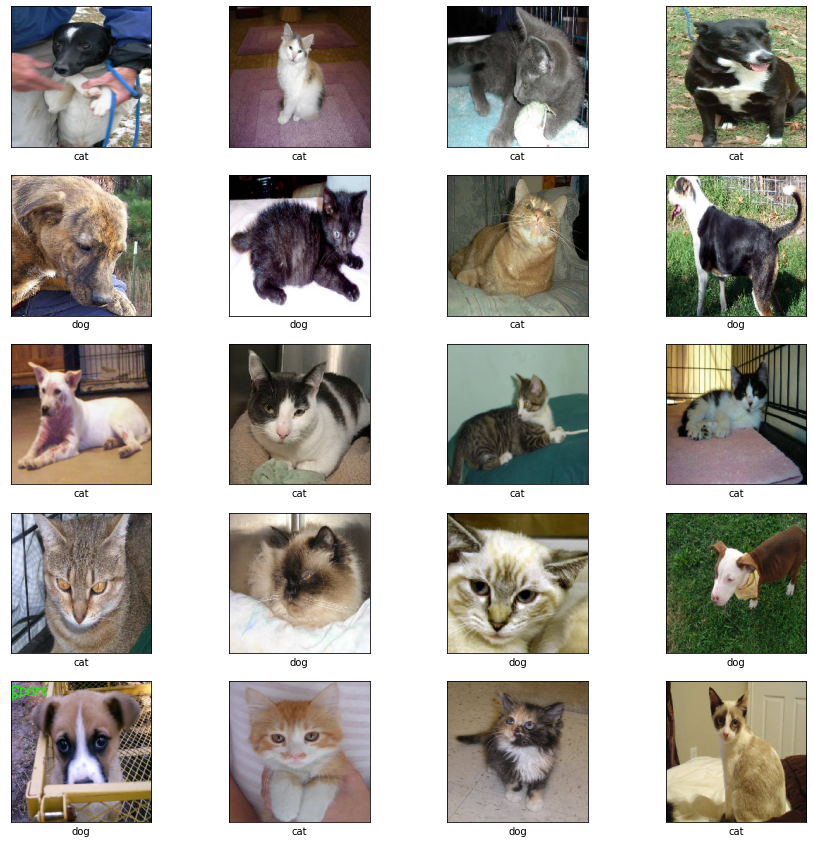

In [133]:
#predictions for test set
prediction = tf.make_tensor_proto(model_final(test_set[0:20]))
prediction = tf.make_ndarray(prediction)
pyplot.figure(figsize=(15,15))
for i in range(20):
    pyplot.subplot(5,4,i+1)
    pyplot.xticks([])
    pyplot.yticks([])
    pyplot.grid(False)
    pyplot.imshow(test_set[i].reshape(200,200,3))
    if prediction[i][0] >= 0.5:
        pyplot.xlabel("cat")
    else:
        pyplot.xlabel("dog")
pyplot.show()

### Same predictions using predict_classes()

In [ ]:
#predictions for test set
prediction = model_final.predict_classes(test_set)
pyplot.figure(figsize=(15,15))
for i in range(20):
    pyplot.subplot(5,4,i+1)
    pyplot.xticks([])
    pyplot.yticks([])
    pyplot.grid(False)
    pyplot.imshow(test_set[i].reshape(200,200,3))
    if prediction[i][0] >= 0.5:
        pyplot.xlabel("cat")
    else:
        pyplot.xlabel("dog")
pyplot.show()